확률분포 기반 이상치 탐지 실습
- 정규분포 가정하에서의 Z-score 방법
- 로버스트 통계량을 이용한 MAD (Median Absolute Deviation)
- 다변량 데이터에서의 마할라노비스 거리


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.covariance import EmpiricalCovariance
import warnings
warnings.filterwarnings('ignore')

1. 시뮬레이션 데이터 생성 (제조업 공정 데이터 가정)

In [2]:
np.random.seed(42)

In [3]:
plt.rcParams['font.family'] ='DejaVu Sans'
plt.style.use('default')

In [4]:
# 이상치 추가 (공정 이상 상황)
normal_temp = np.random.normal(75,3,800)
normal_pressure = np.random.normal(120,5,800)
normal_vibration = np.random.normal(2.5,0.5,800)

In [5]:
# 이상치 추가 (공정 이상 상황)
outlier_indices = np.random.choice(800, 50, replace=False)
temp_with_outliers = normal_temp.copy()
pressure_with_outliers = normal_pressure.copy()
vibration_with_outliers = normal_vibration.copy()

In [6]:
# 극단적 이상치 추가
temp_with_outliers[outlier_indices[:25]] += np.random.normal(15, 3, 25)  # 과열
pressure_with_outliers[outlier_indices[25:]] -= np.random.normal(30, 5, 25)  # 압력 저하

# 데이터프레임 생성
df = pd.DataFrame({
    'temperature': temp_with_outliers,
    'pressure': pressure_with_outliers,
    'vibration': vibration_with_outliers,
    'timestamp': pd.date_range('2024-01-01', periods=800, freq='H')
})

In [7]:
print("=== 제조업 공정 데이터 시뮬레이션 ===")
print(f"데이터 크기: {df.shape}")
print("\n기초 통계:")
print(df[['temperature', 'pressure', 'vibration']].describe())


=== 제조업 공정 데이터 시뮬레이션 ===
데이터 크기: (800, 4)

기초 통계:
       temperature    pressure   vibration
count   800.000000  800.000000  800.000000
mean     75.424916  119.486035    2.507488
std       3.940250    7.444605    0.485334
min      65.276198   80.265258    0.990244
25%      72.966368  116.741403    2.188167
50%      75.143225  120.252015    2.500433
75%      77.125662  123.618467    2.835348
max     103.336753  133.008416    4.096554


2. Z-Score 기반 이상치 탐지

In [8]:
def detect_outliers_zscore(data, threshold=3):
    """
    Z-Score 기반 이상치 탐지
    가정: 데이터가 정규분포를 따름
    임계값: 일반적으로 3 (99.7% 신뢰구간)
    """
    z_scores = np.abs(stats.zscore(data))
    return z_scores > threshold

In [9]:
# 각 변수별 Z-score 이상치 탐지
temp_outliers_z = detect_outliers_zscore(df['temperature'])
pressure_outliers_z = detect_outliers_zscore(df['pressure'])
vibration_outliers_z = detect_outliers_zscore(df['vibration'])
print(f"\n=== Z-Score 이상치 탐지 결과 (임계값: 3) ===")
print(f"온도 이상치: {temp_outliers_z.sum()}개 ({temp_outliers_z.sum()/len(df)*100:.2f}%)")
print(f"압력 이상치: {pressure_outliers_z.sum()}개 ({pressure_outliers_z.sum()/len(df)*100:.2f}%)")
print(f"진동 이상치: {vibration_outliers_z.sum()}개 ({vibration_outliers_z.sum()/len(df)*100:.2f}%)")


=== Z-Score 이상치 탐지 결과 (임계값: 3) ===
온도 이상치: 16개 (2.00%)
압력 이상치: 23개 (2.88%)
진동 이상치: 5개 (0.62%)


3. MAD (Median Absolute Deviation) 기반 이상치 탐지

In [10]:
def detect_outliers_mad(data, threshold=3.5):
    """
    MAD 기반 이상치 탐지 (로버스트 방법)
    중위값과 절대편차의 중위값을 이용
    정규분포가 아닐 때도 사용 가능
    """
    median = np.median(data)
    mad = np.median(np.abs(data - median))
    
    # MAD를 표준편차로 변환 (정규분포 가정시 약 1.4826)
    modified_z_score = 0.6745 * (data - median) / mad
    return np.abs(modified_z_score) > threshold


In [11]:
# MAD 기반 이상치 탐지
temp_outliers_mad = detect_outliers_mad(df['temperature'])
pressure_outliers_mad = detect_outliers_mad(df['pressure'])

print(f"\n=== MAD 이상치 탐지 결과 (임계값: 3.5) ===")
print(f"온도 이상치: {temp_outliers_mad.sum()}개 ({temp_outliers_mad.sum()/len(df)*100:.2f}%)")
print(f"압력 이상치: {pressure_outliers_mad.sum()}개 ({pressure_outliers_mad.sum()/len(df)*100:.2f}%)")


=== MAD 이상치 탐지 결과 (임계값: 3.5) ===
온도 이상치: 20개 (2.50%)
압력 이상치: 25개 (3.12%)


4. 마할라노비스 거리 기반 다변량 이상치 탐지

In [12]:
def detect_outliers_mahalanobis(data, threshold=3):
    """
    마할라노비스 거리 기반 이상치 탐지
    다변량 데이터에서 변수간 상관관계를 고려
    """
    # 공분산 행렬 계산
    cov = EmpiricalCovariance().fit(data)
    
    # 마할라노비스 거리 계산
    mahal_dist = cov.mahalanobis(data)
    
    # 카이제곱 분포를 따른다고 가정 (자유도 = 변수 개수)
    threshold_val = stats.chi2.ppf(0.99, data.shape[1])
    
    return mahal_dist > threshold_val, mahal_dist

In [13]:
# 다변량 이상치 탐지 (온도, 압력, 진동 동시 고려)
multivariate_data = df[['temperature', 'pressure', 'vibration']].values
multivar_outliers, mahal_distances = detect_outliers_mahalanobis(multivariate_data)

print(f"\n=== 마할라노비스 거리 이상치 탐지 결과 ===")
print(f"다변량 이상치: {multivar_outliers.sum()}개 ({multivar_outliers.sum()/len(df)*100:.2f}%)")


=== 마할라노비스 거리 이상치 탐지 결과 ===
다변량 이상치: 40개 (5.00%)


5. 시각화

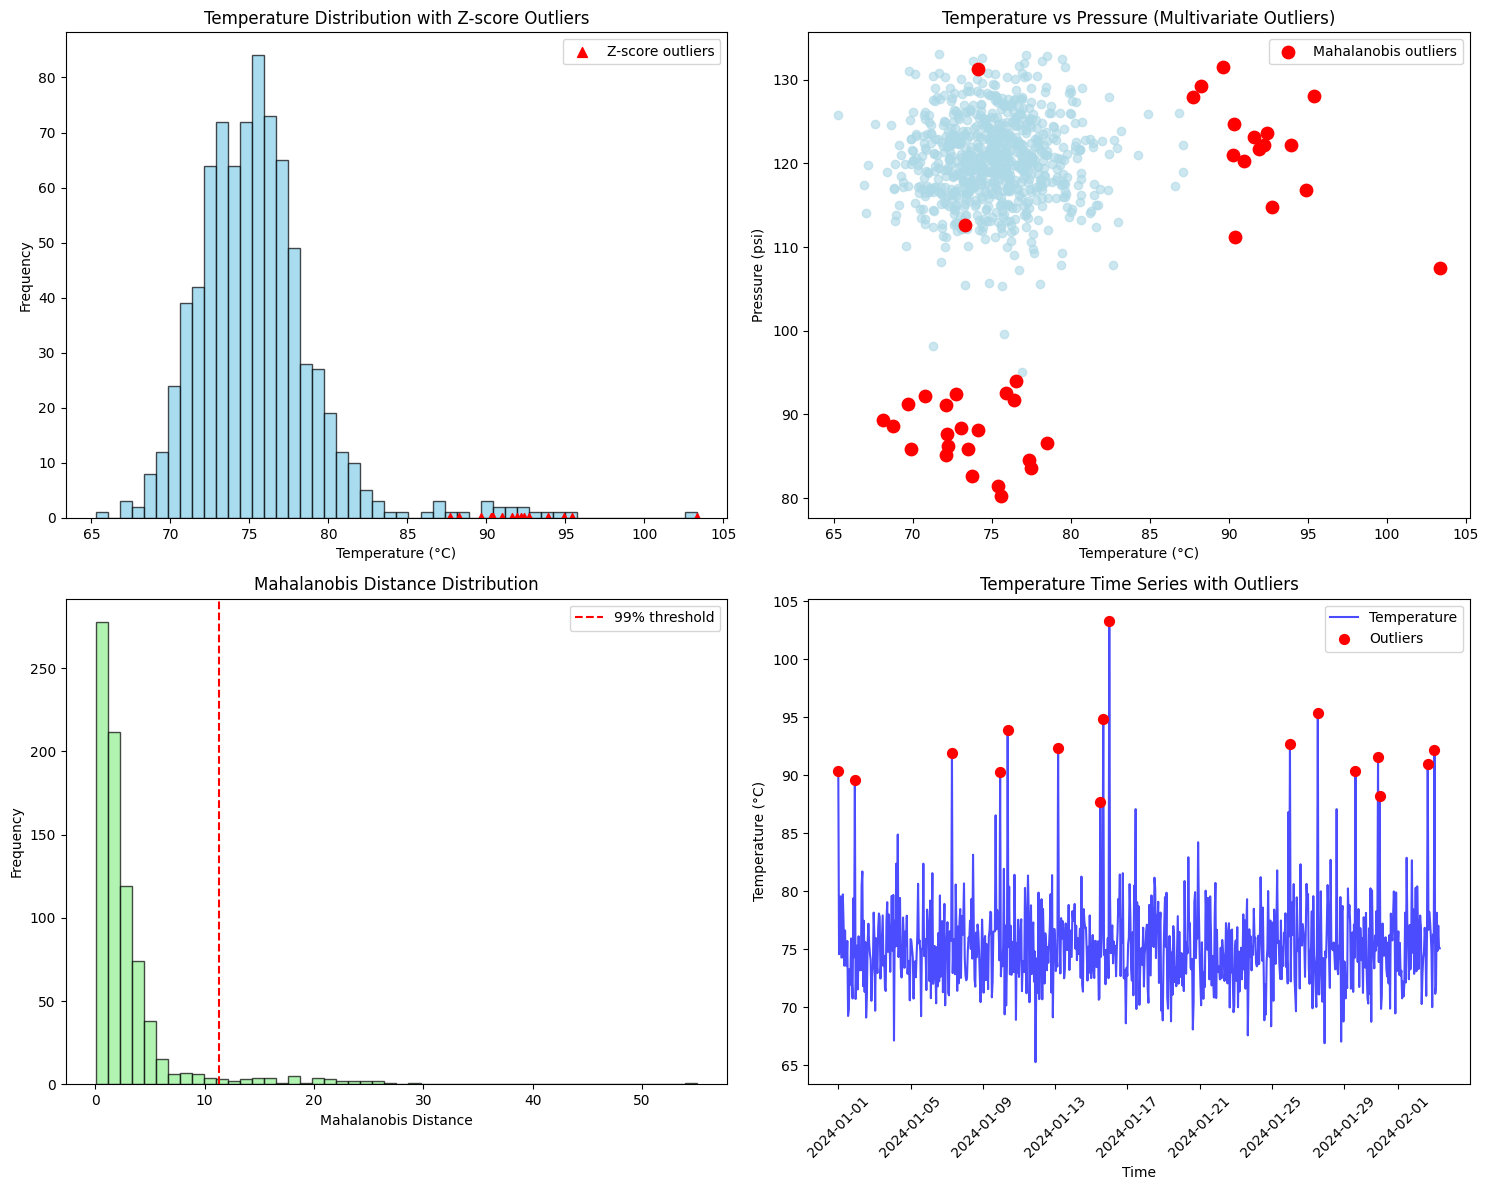

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 온도 데이터 히스토그램과 이상치
axes[0,0].hist(df['temperature'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].scatter(df.loc[temp_outliers_z, 'temperature'], 
                 [0] * temp_outliers_z.sum(), 
                 color='red', s=50, label='Z-score outliers', marker='^')
axes[0,0].set_title('Temperature Distribution with Z-score Outliers')
axes[0,0].set_xlabel('Temperature (°C)')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# 압력 vs 온도 산점도
axes[0,1].scatter(df['temperature'], df['pressure'], alpha=0.6, color='lightblue')
axes[0,1].scatter(df.loc[multivar_outliers, 'temperature'], 
                 df.loc[multivar_outliers, 'pressure'], 
                 color='red', s=80, label='Mahalanobis outliers')
axes[0,1].set_title('Temperature vs Pressure (Multivariate Outliers)')
axes[0,1].set_xlabel('Temperature (°C)')
axes[0,1].set_ylabel('Pressure (psi)')
axes[0,1].legend()

# 마할라노비스 거리 분포
axes[1,0].hist(mahal_distances, bins=50, alpha=0.7, color='lightgreen', edgecolor='black')
axes[1,0].axvline(stats.chi2.ppf(0.99, 3), color='red', linestyle='--', 
                 label='99% threshold')
axes[1,0].set_title('Mahalanobis Distance Distribution')
axes[1,0].set_xlabel('Mahalanobis Distance')
axes[1,0].set_ylabel('Frequency')
axes[1,0].legend()

# 시계열 시각화 (이상치 표시)
time_series_data = df.set_index('timestamp')
axes[1,1].plot(time_series_data.index, time_series_data['temperature'], 
              alpha=0.7, color='blue', label='Temperature')
outlier_times = time_series_data.index[temp_outliers_z]
outlier_temps = time_series_data.loc[temp_outliers_z, 'temperature']
axes[1,1].scatter(outlier_times, outlier_temps, color='red', s=50, 
                 label='Outliers', zorder=5)
axes[1,1].set_title('Temperature Time Series with Outliers')
axes[1,1].set_xlabel('Time')
axes[1,1].set_ylabel('Temperature (°C)')
axes[1,1].legend()
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

6. 이상치 탐지 방법 비교

In [18]:
comparison_df = pd.DataFrame({
    'Z_Score_Temp': temp_outliers_z,
    'MAD_Temp': temp_outliers_mad,
    'Z_Score_Pressure': pressure_outliers_z,
    'Multivariate': multivar_outliers
})

print("\n=== 이상치 탐지 방법별 비교 ===")
print("방법별 탐지된 이상치 개수:")
for col in comparison_df.columns:
    print(f"{col}: {comparison_df[col].sum()}개")



=== 이상치 탐지 방법별 비교 ===
방법별 탐지된 이상치 개수:
Z_Score_Temp: 16개
MAD_Temp: 20개
Z_Score_Pressure: 23개
Multivariate: 40개


In [19]:
# 방법별 교집합 분석
z_and_mad = temp_outliers_z & temp_outliers_mad
print(f"\nZ-Score와 MAD 둘 다 탐지: {z_and_mad.sum()}개")
z_or_mad = temp_outliers_z | temp_outliers_mad
print(f"Z-Score 또는 MAD 중 하나라도 탐지: {z_or_mad.sum()}개")


Z-Score와 MAD 둘 다 탐지: 16개
Z-Score 또는 MAD 중 하나라도 탐지: 20개


7. 통계적 검정을 통한 정규성 확인

In [22]:
print("\n=== 정규성 검정 (Shapiro-Wilk Test) ===")
stat_temp, p_temp = stats.shapiro(df['temperature'][:100])  # 샘플 크기 제한
stat_pressure, p_pressure = stats.shapiro(df['pressure'][:100])
print(f"온도 데이터 정규성: p-value = {p_temp:.6f}")
if p_temp > 0.05:
    print("→ 정규분포를 따른다고 볼 수 있음 (Z-score 적합)")
else:
    print("→ 정규분포를 따르지 않음 (MAD 방법 권장)")

print(f"압력 데이터 정규성: p-value = {p_pressure:.6f}")
if p_pressure > 0.05:
    print("→ 정규분포를 따른다고 볼 수 있음 (Z-score 적합)")
else:
    print("→ 정규분포를 따르지 않음 (MAD 방법 권장)")

print("\n=== 실습 완료 ===")
print("다음 단계: 탐지된 이상치에 대한 처리 방법 결정")
print("1. 제거 (deletion)")
print("2. 변환 (transformation)")  
print("3. 대체 (imputation)")
print("4. 별도 분석 (separate analysis)")


=== 정규성 검정 (Shapiro-Wilk Test) ===
온도 데이터 정규성: p-value = 0.000009
→ 정규분포를 따르지 않음 (MAD 방법 권장)
압력 데이터 정규성: p-value = 0.000000
→ 정규분포를 따르지 않음 (MAD 방법 권장)

=== 실습 완료 ===
다음 단계: 탐지된 이상치에 대한 처리 방법 결정
1. 제거 (deletion)
2. 변환 (transformation)
3. 대체 (imputation)
4. 별도 분석 (separate analysis)
